# Bistability in photonic crystal microcavities

## Introduction

Here we take advantage of Tidy3D's nonlinear capability to demonstrate optical bistability. We base this example on the paper from Yanik et al. titled [_High-contrast all-optical bistable switching in photonic crystal microcavities_](https://doi.org/10.1063/1.1615835). In this paper, a photonic crystal waveguide coupled with a point-defect cavity with Kerr nonlinearity achieves high-contrast transmission between two stable states.

<center><img src="img/bistability.png" alt="diagram" width="600"/></center>

For more simulation examples, please visit our [examples page](https://www.flexcompute.com/tidy3d/examples/). If you are new to the finite-difference time-domain (FDTD) method, we highly recommend going through our [FDTD101](https://www.flexcompute.com/fdtd101/) tutorials. FDTD simulations can diverge due to various reasons. If you run into any simulation divergence issues, please follow the steps outlined in our [troubleshooting guide](https://www.flexcompute.com/tidy3d/examples/notebooks/DivergedFDTDSimulation/) to resolve it.

## Setup

We first import the packages we'll need.

In [1]:
# standard python imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# tidy3D import
import tidy3d as td
import tidy3d.web as web
import gdstk
import scipy

The waveguide-cavity system we examine is given by a square lattice (with lattice constant a) of high dielectric rods ($n$ = 3.5) of radius $.2a$. The waveguide is given by removing a row of these rods, and the cavity is given by point defect in the crystal - instead of a rod, the defect is an ellipse with major and minor axes of $a$ and $2a$, respectively. Here we will set $a$ = 1.

To build this in Tidy3D, we take advantage of the "square_cylinder_array" method in the [common photonic crystal structures](https://www.flexcompute.com/tidy3d/examples/notebooks/PhotonicCrystalsComponents/) page in the Tidy3D learning center.

Since we are dealing with a photonic crystal with discrete translational symmetry, we can get spurious reflections if we simply use a PML boundary condition. Thus instead we use the custom abosrbing condition given in Mekis et al.'s [Absorbing boundary conditions for FDTD simulations of photonic crystal waveguides](https://ieeexplore.ieee.org/document/819374). This is a $k$-matched distributed Bragg reflector waveguide consisting of a periodic array of alternating periodic slabs, with the waveguide given by a single line defect of a single slab with larger thickness. Since this waveguide has continuous translational symmetry, we can now feed it into a standard PML boundary. For simplicity, in defining the parameters for this waveguide, we use the parameters given in Mekis et al.

In [2]:
def square_cylinder_array(
    x0,
    y0,
    z0,
    R,
    hole_spacing_x,
    hole_spacing_y,
    n_x,
    n_y,
    height,
    medium,
    reference_plane="bottom",
    sidewall_angle=0,
    axis=2,
):
    # parameters
    # ------------------------------------------------------------
    # x0: x coordinate of center of the array (um)
    # y0: y coordinate of center of the array (um)
    # z0: z coordinate of center of the array (um)
    # R: radius of the circular holes (um)
    # hole_spacing_x: distance between centers of holes in x direction (um)
    # hole_spacing_y: distance between centers of holes in y direction (um)
    # n_x: number of cylinders in x direction
    # n_y: number of cylinders in y direction
    # height: height of array
    # medium: medium of the cylinders
    # reference_plane
    # sidewall_angle: angle slant of cylinders
    # axis

    cylinder_group = []

    start_x, start_y = x0 + hole_spacing_x * (1 - n_x) / 2, y0 + hole_spacing_y * (1 - n_y) / 2
    for i in range(0, n_x):
        for j in range(0, n_y):
            c = td.Cylinder(
                axis=axis,
                sidewall_angle=sidewall_angle,
                reference_plane=reference_plane,
                radius=R,
                center=(start_x + i * hole_spacing_x, start_y + j * hole_spacing_y, z0),
                length=height,
            )
            cylinder_group.append(c)
    structure = td.Structure(geometry=td.GeometryGroup(geometries=cylinder_group), medium=medium)
    return structure

def DBR(
    x0,
    y0,
    z0,
    length,
    thickness,
    spacing,
    num_layers,
    medium,
    direction='+',
):
    # parameters
    # ------------------------------------------------------------
    # x0: x coordinate of center of the array (um)
    # y0: y coordinate of center of the array (um)
    # z0: z coordinate of center of the array (um)
    # length: Length of slabs
    # thickness: thickness of slabs (um)
    # spacing: space between each slab (um)
    # num_layers: number of slabs
    # medium: medium of the slabs
    # direction: does it extend right or left from the center?

    slab_group = []
    orientation = 1
    if direction != '+':
        orientation = -1
    start_x, start_y = x0 + orientation*length/2, y0 - num_layers/2*a
    for i in range(0, num_layers+1):
        if i != num_layers//2:
            s = td.Box(
                center=(start_x, start_y+i*a, 0),
                size=(length, thickness, td.inf)
            )
            slab_group.append(s)
    structure = td.Structure(geometry=td.GeometryGroup(geometries=slab_group), medium=medium)
    return structure

## Define Structure

We now carve out our waveguide and introduce or ellipse point defect. While the end goal of this notebook is to take advantage of the ellipse's nonlinearity, we must first find the resonant frequency of the cavity when it behaves linearly - thus we set the material as a linear material for now.

We also want to compute $\kappa$, a nonlinear feedback parameter crucial to our simulations - more on this later.

In [3]:
n_rods = 3.5
rod = td.Medium(permittivity=n_rods**2)
n_air = 1
air = td.Medium(permittivity=n_air)

# Kerr coefficient
n2 = 1.5e-17 # m^2/W, from paper
n2 *= 1e12 # convert to um^2/W

a = 1
radius = 0.2*a
block_rows = 21
block_cols = 17

######################### SIMPLE CRYSTAL ##########################
block = square_cylinder_array(0, 0, -a, radius, a, a,
                                     block_cols, block_rows, td.inf, rod, reference_plane='middle')
######################### WAVEGUIDE WITHOUT CAVITY ##########################
waveguide = td.Structure(
    geometry=td.Box(
        center=[0, 0, 0],
        size=[td.inf, a, td.inf],
    ),
    medium=air,
    name="waveguide",
)
########################### WAVEGUIDE WITH CAVITY ###########################
cavity_air = td.Structure(
    geometry=td.Box(
        center=[0, -3*a, 0],
        size=[a, a, td.inf],
    ),
    medium=air,
    name="cavity air",
)
air_block = td.Structure(
    geometry=td.Box(
        center=[-22*a, 0, 0],
        size=[30*a - a/2, td.inf, td.inf],
    ),
    medium=air,
    name="air block",
)

################### DISTRIBUTED BRAGG REFLECTOR BOUNDARY ###################
thickness = 0.25*a
n_DBR = 10.2
dbr_med = td.Medium(permittivity=n_DBR**2)
dbr_boundary = DBR(block_cols*a/2, 0, 0, 20, thickness, a, block_rows-1, dbr_med)

################################## CAVITY ##################################
major = a
minor = 0.2*a
cavity_gdstk = gdstk.ellipse((0, -3*a), (minor/2, major/2))
cavity_cell = gdstk.Cell("Ellipse")
cavity_cell.add(cavity_gdstk)
cavity = td.PolySlab.from_gds(
    cavity_cell,
    gds_layer=0,
    gds_dtype=0,
    axis=2,
    slab_bounds=(-td.inf, td.inf),
    reference_plane='bottom',
)[0]

cavity_structure = td.Structure(
    geometry=cavity,
    medium=rod,
)

In [4]:
freqs = np.linspace(1.08e14, 1.1e14, 1000)
freq0 = freqs[len(freqs)//2]
fwidth = freqs[-1]-freqs[0]

run_time = 10000/freq0

# simulation parameters
x_span = 27*a
y_span = 17*a

min_steps_per_wvl = 30
gridSpecUniform = td.GridSpec.uniform(dl=a/24)

pulse = td.GaussianPulse(freq0=freq0, fwidth=fwidth)
source_distance = 9
gaussianBeam = td.GaussianBeam(
    center=[-source_distance*a, 0, 0],
    size=[0,td.inf,td.inf],
    source_time=pulse,
    direction='+',
    pol_angle=np.pi/2,
    waist_radius=2.0*a
)

## Things to Compute in the Linear Case

We wish to compute the resonant frequency $\omega_{res}$ and the characteristic power of the cavity, given by

<center>$P_0=1/[\kappa Q^2 n_2 /c]$</center>

where $Q$ is the cavity quality factor, $n_2$ is the Kerr coefficient we'll use, and $\kappa$ is a nonlinear feedback parameter, a measure of the efficiency of the feedback system.
We then use this to compute the cavity decay rate $\gamma=\omega_{res}/(2Q)$.

To compute $\omega_{res}$ and $Q$, we use Tidy3D's [resonance finder](https://docs.flexcompute.com/projects/tidy3d/en/v1.8.0/_autosummary/tidy3d.plugins.ResonanceFinder.html).

In computing $\kappa$, we use the definition given by Soljacic et al. in [_Optimal bistable switching in nonlinear photonic crystals_](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.66.055601):

<center>$\kappa=(\frac{c}{\omega_{res}})^2\frac{\int d^2r[|E(r)\cdot E(r)|^2 + 2|E(r)\cdot E^*(r)|^2]n^2(r)n_2(r)}{[\int d^2r|E(r)|^2n^2(r)]^2n_2}$</center>

## Define Monitors and Simulation

We now input our monitors - a field monitor and permittivity monitor over the extent of the cavity's mode to compute $\kappa$ (field_monitor_cavity and permittivity_monitor_cavity), a field time monitor to compute our resonant frequency and cavity quality factor (field_time_monitor_wg), and a flux monitor at the end of the waveguide to find transmission vs frequency (flux_monitor).

In [5]:
cavity_monitor_size = 7
field_monitor_cavity = td.FieldTimeMonitor(
            fields=["Ez"],
            center=[0, -3*a, 0],
            size=[cavity_monitor_size*a, cavity_monitor_size*a, 0],
            start=run_time*8/10,
            stop=run_time*8/10,
            name='field cavity',
        )
permittivity_monitor_cavity = td.PermittivityMonitor(
            center=[0, -3*a, 0],
            size=[cavity_monitor_size*a, cavity_monitor_size*a, 0],
            freqs=freqs[0],
            name='permittivity cavity',
        )

flux_distance = 4.5

field_time_monitor_wg = td.FieldTimeMonitor(
            fields=["Ez"],
            center=[flux_distance*a, 0, 0],
            size=(0, 0, 0),
            start=run_time*8/10, # time to start monitoring after source has decayed, units of 1/frequency bandwidth
            name='field time wg',
        )
flux_monitor = td.FluxMonitor(
    center=[flux_distance*a, 0, 0],
    size=[0,td.inf,td.inf],
    freqs=freqs,
    normal_dir='+',
    name="flux",
)

x_boundary = td.Boundary(minus=td.PML(num_layers=80),plus=td.PML(num_layers=80))

sim_linear = td.Simulation(
    center=(0, -a, 0),
    size=[x_span, y_span, 0],
    medium=air,
    grid_spec=gridSpecUniform,
    structures=[block, waveguide, cavity_air, cavity_structure, dbr_boundary, air_block],
    sources=[gaussianBeam],
    monitors=[field_monitor_cavity, permittivity_monitor_cavity, field_time_monitor_wg, flux_monitor],
    run_time=run_time,
    boundary_spec=td.BoundarySpec(
        x=x_boundary, y=td.Boundary.periodic(), z=td.Boundary.periodic()
    ),
    shutoff=False
)

## Visualize Simulation

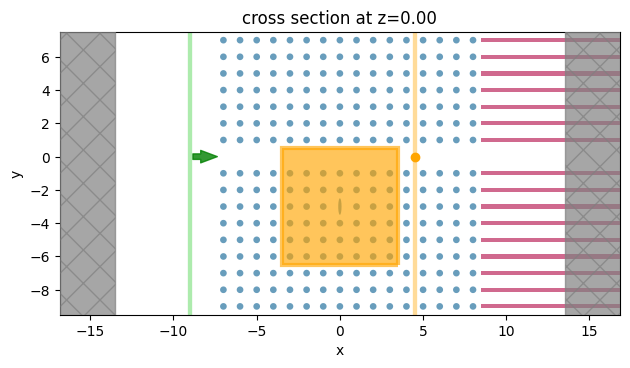

In [6]:
sim_linear.plot(z=0)
plt.show()

## Run Simulation

In [7]:
sim_linear_data = web.run(sim_linear, task_name="bistable_pc_cavity")

11:19:03 UTC Created task 'bistable_pc_cavity' with task_id                     
             'fdve-9b1c25ca-cdc6-4d22-b13f-be4a6ab52ae1' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=738148;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9b1c25ca-cdc6-4d22-b13f-be4a6ab52ae1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=813785;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9b1c25ca-cdc6-4d22-b13f-be4a6ab52ae1\taskId]8;;\]8;id=738148;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9b1c25ca-cdc6-4d22-b13f-be4a6ab52ae1\=]8;;\]8;id=44406;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9b1c25ca-cdc6-4d22-b13f-be4a6ab52ae1\fdve]8;;\]8;id=738148;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9b1c25ca-cdc6-4d22-b13f-be4a6ab52ae1\-9b1c25ca-cdc]8;;\
             ]8;id=738148;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9b1c25ca-cdc6-4d22-b13f-be4a6ab52ae1\6-4d22-b13f-be4a6ab52ae1']8;;\.

Output()

11:19:12 UTC status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

11:19:17 UTC status = preprocess

11:19:20 UTC Maximum FlexCredit cost: 0.097. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

Output()

11:22:43 UTC status = postprocess

Output()

11:22:44 UTC status = success

             View simulation result at                                          
             ]8;id=834158;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9b1c25ca-cdc6-4d22-b13f-be4a6ab52ae1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=379134;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9b1c25ca-cdc6-4d22-b13f-be4a6ab52ae1\taskId]8;;\]8;id=834158;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9b1c25ca-cdc6-4d22-b13f-be4a6ab52ae1\=]8;;\]8;id=853095;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9b1c25ca-cdc6-4d22-b13f-be4a6ab52ae1\fdve]8;;\]8;id=834158;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9b1c25ca-cdc6-4d22-b13f-be4a6ab52ae1\-9b1c25ca-cdc]8;;\
             ]8;id=834158;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9b1c25ca-cdc6-4d22-b13f-be4a6ab52ae1\6-4d22-b13f-be4a6ab52ae1']8;;\.

Output()

11:22:45 UTC loading simulation from simulation_data.hdf5

## Calculate Linear Resonance

We plot the flux through the waveguide vs frequency to verify that the the transmission vanishes on cavity resonance.

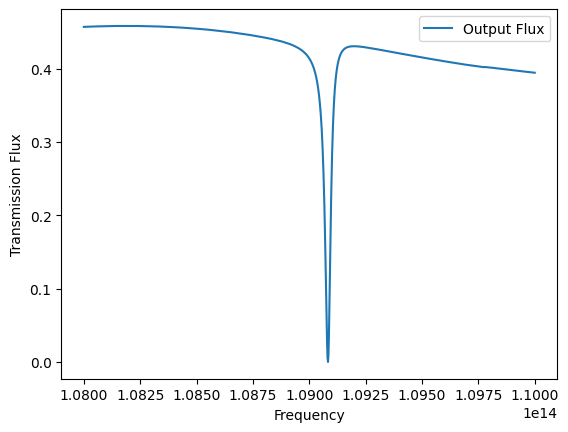

In [8]:
flx_cavity = sim_linear_data["flux"].flux
plt.plot(freqs, flx_cavity, label="Output Flux")
plt.xlabel("Frequency")
plt.ylabel("Transmission Flux")
plt.legend()
plt.show()

## Compute Resonance Frequency and Q

We import Tidy3D's resonance finder 

In [9]:
from tidy3d.plugins.resonance import ResonanceFinder

resfinder = ResonanceFinder(freq_window=(freqs[0], freqs[-1]))

In [10]:
res_data = resfinder.run_scalar_field_time(signal=sim_linear_data.monitor_data["field time wg"].Ez)
res_data = res_data.sortby("error")
res_data.to_dataframe()

,decay,Q,amplitude,phase,error
freq,,,,,
1.090839e+14,9.367332e+10,3658.429958,2.098768e-04,1.132464,0.000001
1.110648e+14,1.789903e+10,19493.804387,2.364744e-05,0.274660,0.000001
1.097692e+14,2.507239e+10,13754.175218,1.640017e-05,2.822008,0.000001
1.082280e+14,1.380102e+10,24636.472365,4.930391e-07,0.022443,0.000012
1.087748e+14,1.086547e+11,3145.066631,5.879911e-06,1.442527,0.000021
1.136704e+14,-3.535689e+10,-10100.039468,1.034523e-06,1.747212,0.000064


As you can see, the resonant frequency here agrees with the transmission spectrum shown above.

In [11]:
Q = res_data.Q[0].item()
fres = res_data.freq[0].item()
w_res = fres*2*np.pi
gamma = w_res/2/Q

## Computing $\kappa$

We take advantage of our permittivity monitor data to use our $n(r),n_2(r)$ functions needed in the integrals of the above definition of $\kappa$. Note that, due to symmetry, the only nonzero field component is $E_z$. To get $n_2(r)$, we mask the permittivity monitor outside of the ellipse, and matshow to verify that this window only contains the nonlinear ellipse, and does not cut it off. We then compute the integrals and solve for $\kappa$:

kappa =  0.1666128771124902


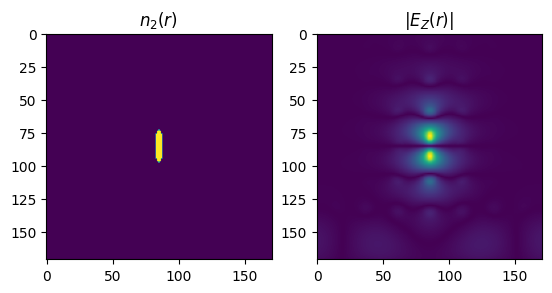

In [12]:
n_r = np.where(sim_linear_data.monitor_data['permittivity cavity'].eps_zz[1:,1:,0,0] != 1.+0.j, n_rods, 1)
n2_r = np.zeros(n_r.shape)
x, y = n_r.shape

# compute length between entries in monitor data
entry_length_x, entry_length_y = cavity_monitor_size*a/x, cavity_monitor_size*a/y
# compute number of entries that span a/2
wx, wy = int(a/entry_length_x/2), int(3*a/entry_length_y/4)
# coordinates in entries of the monitor
rod_x, rod_y = x//2, y//2 #+ wy//2

# isolate rod within window for n_2(r)
n2_r[rod_x-wx:rod_x+wx, rod_y-wy:rod_y+wy] = n_r[rod_x-wx:rod_x+wx, rod_y-wy:rod_y+wy]
n2_r = np.where(n2_r > 1, n2, 0)

# get field components at resonant frequency
Ez = sim_linear_data.monitor_data['field cavity'].Ez[:,:,0,0]

integrand_num = (np.abs(Ez*Ez)**2 + 2*np.abs(Ez*np.conjugate(Ez))**2) * n_r**2 * n2_r
integrand_den = (np.abs(Ez)**2 * n_r**2)

int_num = integrand_num.integrate(coord=("x", "y")).item()
int_den = integrand_den.integrate(coord=("x", "y")).item()

kappa = (td.C_0/w_res)**2 * int_num/ ((int_den)**2 * n2)
print("kappa = ",kappa)

f, ax = plt.subplots(1,2) 
ax[0].imshow(n2_r.T)
ax[0].set_title("$n_2(r)$")
ax[1].imshow(np.abs(Ez).T)
ax[1].set_title("$|E_Z(r)|$")
plt.show()

We can now define the characteristic power of the cavity:

In [13]:
P_0 = td.C_0/(kappa*Q**2*w_res*n2)

## Waveguide normalization

We need to normalize the input power of our nonlinear simulation by the transmission intrinsic to the waveguide (without the cavity). The power frequency of our nonlinear source must be detuned by at least $\delta=\sqrt{3}$, where

<center>$\delta=(\omega_{res}-\omega_{input})/\gamma$,</center>

in order to be considered bistable. In Yanik et al., the frequency is detuned by $2\sqrt{3}$.

In [14]:
detuning = 2*np.sqrt(3)
detuned_freq = (w_res-detuning*gamma)/(2*np.pi)
print(detuned_freq)

109032284139038.44


## Define Waveguide-Only simulation for Normalization

We now update the previous simulation to only contain the waveguide in order to properly gauge the waveguide power input:

We take advantage of Tidy3D's CustomSourceTime method to use this power function as a source with our desired detuned frequency:

In [15]:
sim_waveguide = sim_linear.updated_copy(monitors=[flux_monitor],
                                        structures=[block, waveguide, dbr_boundary, air_block])

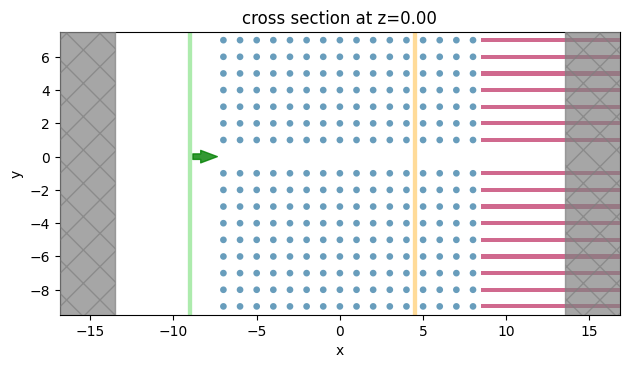

In [16]:
sim_waveguide.plot(z=0)
plt.show()

In [17]:
sim_waveguide_data = web.run(sim_waveguide, task_name="bistable_pc")

11:23:17 UTC Created task 'bistable_pc' with task_id                            
             'fdve-3bd90688-e1ee-4c3f-a6f2-3a14682c0626' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=333469;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3bd90688-e1ee-4c3f-a6f2-3a14682c0626\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=953646;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3bd90688-e1ee-4c3f-a6f2-3a14682c0626\taskId]8;;\]8;id=333469;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3bd90688-e1ee-4c3f-a6f2-3a14682c0626\=]8;;\]8;id=244333;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3bd90688-e1ee-4c3f-a6f2-3a14682c0626\fdve]8;;\]8;id=333469;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3bd90688-e1ee-4c3f-a6f2-3a14682c0626\-3bd90688-e1e]8;;\
             ]8;id=333469;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3bd90688-e1ee-4c3f-a6f2-3a14682c0626\e-4c3f-a6f2-3a14682c0626']8;;\.

Output()

11:23:19 UTC status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

11:23:32 UTC status = preprocess

11:23:34 UTC Maximum FlexCredit cost: 0.097. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

Output()

Output()

11:26:57 UTC status = postprocess

11:26:58 UTC status = success

             View simulation result at                                          
             ]8;id=693438;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3bd90688-e1ee-4c3f-a6f2-3a14682c0626\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=747743;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3bd90688-e1ee-4c3f-a6f2-3a14682c0626\taskId]8;;\]8;id=693438;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3bd90688-e1ee-4c3f-a6f2-3a14682c0626\=]8;;\]8;id=166280;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3bd90688-e1ee-4c3f-a6f2-3a14682c0626\fdve]8;;\]8;id=693438;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3bd90688-e1ee-4c3f-a6f2-3a14682c0626\-3bd90688-e1e]8;;\
             ]8;id=693438;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3bd90688-e1ee-4c3f-a6f2-3a14682c0626\e-4c3f-a6f2-3a14682c0626']8;;\.

Output()

11:26:59 UTC loading simulation from simulation_data.hdf5

In [18]:
flx_waveguide = sim_waveguide_data["flux"].flux
detuned_transmission = sim_waveguide_data["flux"].flux.sel(f=detuned_freq, method="nearest").item()
print("Transmission at detuned frequency: ", detuned_transmission)

Transmission at detuned frequency:  0.43756386637687683


## Define Input Power

We define the source. We first use scipy's erf function to ramp up input power from 0 to $3.95P_0$, hold this power, then add a pulse with peak power of $20.85P_0$ to perform the switch, then go back down to $3.95P_0$. The frequency of this power curve is detuned by $\delta=2\sqrt{3}$.

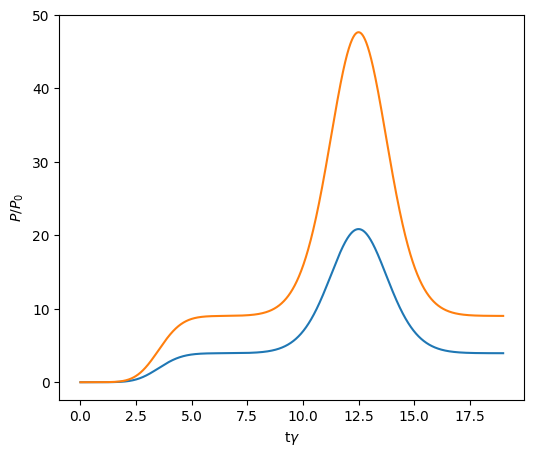

In [19]:
# ramp up to CW
muramp = 3/gamma # central time for ramp up
sigmaramp = 1/gamma # time width for ramp up

PCW = 3.95*P_0
# switching pulse
mupulse = 12.5/gamma
sigmapulse = 1.5/gamma
Ppeak = 20.85*P_0

def power_curve(t):
    t /= gamma
    sig = np.sqrt(PCW)*(1 + scipy.special.erf((t - muramp)/(sigmaramp*np.sqrt(2))))/2
    sig += (np.sqrt(Ppeak) - np.sqrt(PCW))*np.exp(-((t - mupulse)/sigmapulse)**2/2)
    return sig

nt = 2000
tmax = 19/gamma
times = np.linspace(0, tmax, nt)
pulse_run_time = tmax

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.set_xlabel('t$\gamma$')
ax.set_ylabel('$P/P_0$')

plt.plot(times*gamma, np.abs(power_curve(times*gamma))**2/P_0)
plt.plot(times*gamma, np.abs(power_curve(times*gamma))**2/P_0/detuned_transmission)
plt.show()

We now create our source time with power amplitude given by this power curve, normalized with the transmission through the waveguide waveguide at our detuned frequency.

## Normalization Note:

Notice that we also normalize by a factor of two. This is because, in Yanik et al., peak power is given, whereas the source power gives the cycle average power, which is 1/2 the peak power, so we need to multiply by 2 to get the peak power.

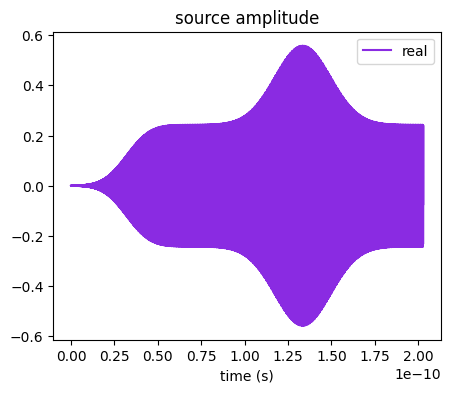

In [20]:
source_time = td.CustomSourceTime.from_values(freq0=detuned_freq,
                                              fwidth=fwidth,
                                              values=power_curve(times*gamma)/np.sqrt(2*detuned_transmission),
                                              dt=times[1]-times[0])
nonlinear_source = gaussianBeam.updated_copy(center=[-source_distance*a, 0, 0], source_time=source_time)
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
source_time.plot(np.linspace(0, pulse_run_time, 20000), ax=ax)
plt.show()

## Nonlinear Simulation

Now we add nonlinearity to the cavity, and input a pulse to switch between bistable states. The bistable states will have the same input power at the same (detuned from $\omega_{res}$) frequency, but will have very different transmissions through the waveguide.

To add nonlinearity, we compute $\chi^{(3)}$ according to the formula:

<center>$\chi^{(3)}=\frac{n_2nRe(n)}{283}$</center>


and add this to the ellipse geometry we've already defined:

In [21]:
chi3 = n2*n_rods*np.real(n_rods)/283

cavityMedium = td.Medium(permittivity=n_rods**2,
                        nonlinear_spec=td.NonlinearSpec(models=[td.NonlinearSusceptibility(chi3=chi3)],
                                                        num_iters=10))

cavity_structure_nonlinear = td.Structure(
    geometry=cavity,
    medium=cavityMedium,
)

## Define Further Monitors

We wish to examine the field profiles before and after the pulse at the different stable states, so we add [FieldTimeMonitors](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.FieldTimeMonitor.html) at these times.

In [22]:
field_before_pulse = td.FieldTimeMonitor(
            center=[0, 0, 0],
            size=[td.inf,td.inf,0],
            name='field before pulse',
            start=6/gamma,
            stop=6/gamma,
            fields=['Ez']
        )
field_after_pulse = td.FieldTimeMonitor(
            center=[0, 0, 0],
            size=[td.inf,td.inf,0],
            name='field after pulse',
            start=19/gamma,
            stop=19/gamma,
            fields=['Ez']
        )
flux_t = td.FluxTimeMonitor(
            center=[flux_distance*a, 0, 0],
            size=[0,td.inf,td.inf],
            name="flux t",
            normal_dir='+',
        )

11:27:18 UTC WARNING: The monitor 'interval' field was left as its default      
             value, which will set it to 1 internally. A value of 1 means that  
             the data will be sampled at every time step, which may potentially 
             produce more data than desired, depending on the use case. To      
             reduce data storage, one may downsample the data by setting        
             'interval > 1' or by choosing alternative 'start' and 'stop' values
             for the time sampling. If you intended to use the highest          
             resolution time sampling, you may suppress this warning by         
             explicitly setting 'interval=1' in the monitor.                    

## Define Nonlinear Simulation

In [23]:
sim_nonlinear = sim_linear.updated_copy(run_time=pulse_run_time,
                                        medium=air,
                                        sources=[nonlinear_source],
                                        monitors=[field_before_pulse, field_after_pulse, flux_t],
                                        structures=[block, waveguide, cavity_air, cavity_structure_nonlinear, air_block, dbr_boundary],
                                       )

             WARNING: 'normalize_index' 0 is a source with 'CustomSourceTime'   
             time dependence. Normalizing frequency-domain monitors by this     
             source is only meaningful if field decay occurs.                   

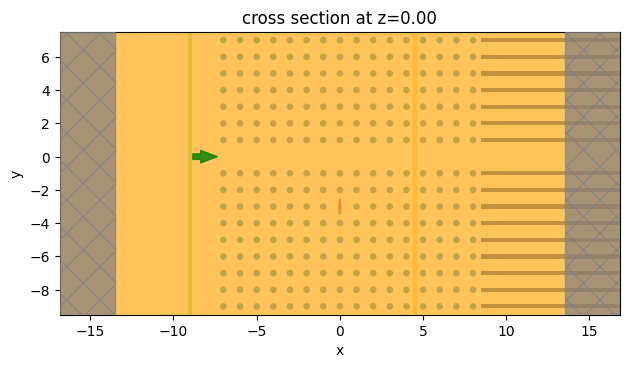

In [24]:
sim_nonlinear.plot(z=0)
plt.show()

In [25]:
sim_nonlinear_data = web.run(sim_nonlinear, task_name="bistable_pc")

11:27:19 UTC WARNING: Simulation has 2.08e+06 time steps. The 'run_time' may be 
             unnecessarily large, unless there are very long-lived resonances.  

             Created task 'bistable_pc' with task_id                            
             'fdve-99ac8438-f707-496c-90b3-a985d5f3c33d' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=853341;https://tidy3d.simulation.cloud/workbench?taskId=fdve-99ac8438-f707-496c-90b3-a985d5f3c33d\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=610367;https://tidy3d.simulation.cloud/workbench?taskId=fdve-99ac8438-f707-496c-90b3-a985d5f3c33d\taskId]8;;\]8;id=853341;https://tidy3d.simulation.cloud/workbench?taskId=fdve-99ac8438-f707-496c-90b3-a985d5f3c33d\=]8;;\]8;id=936455;https://tidy3d.simulation.cloud/workbench?taskId=fdve-99ac8438-f707-496c-90b3-a985d5f3c33d\fdve]8;;\]8;id=853341;https://tidy3d.simulation.cloud/workbench?taskId=fdve-99ac8438-f707-496c-90b3-a985d5f3c33d\-99ac8438-f70]8;;\
             ]8;id=853341;https://tidy3d.simulation.cloud/workbench?taskId=fdve-99ac8438-f707-496c-90b3-a985d5f3c33d\7-496c-90b3-a985d5f3c33d']8;;\.

Output()

11:27:28 UTC status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

11:27:35 UTC status = preprocess

11:27:38 UTC Maximum FlexCredit cost: 0.326. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

Output()

11:32:46 UTC status = postprocess

Output()

11:32:49 UTC status = success

11:32:50 UTC View simulation result at                                          
             ]8;id=548934;https://tidy3d.simulation.cloud/workbench?taskId=fdve-99ac8438-f707-496c-90b3-a985d5f3c33d\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=836188;https://tidy3d.simulation.cloud/workbench?taskId=fdve-99ac8438-f707-496c-90b3-a985d5f3c33d\taskId]8;;\]8;id=548934;https://tidy3d.simulation.cloud/workbench?taskId=fdve-99ac8438-f707-496c-90b3-a985d5f3c33d\=]8;;\]8;id=665950;https://tidy3d.simulation.cloud/workbench?taskId=fdve-99ac8438-f707-496c-90b3-a985d5f3c33d\fdve]8;;\]8;id=548934;https://tidy3d.simulation.cloud/workbench?taskId=fdve-99ac8438-f707-496c-90b3-a985d5f3c33d\-99ac8438-f70]8;;\
             ]8;id=548934;https://tidy3d.simulation.cloud/workbench?taskId=fdve-99ac8438-f707-496c-90b3-a985d5f3c33d\7-496c-90b3-a985d5f3c33d']8;;\.

Output()

11:32:52 UTC loading simulation from simulation_data.hdf5

             WARNING: 'normalize_index' 0 is a source with 'CustomSourceTime'   
             time dependence. Normalizing frequency-domain monitors by this     
             source is only meaningful if field decay occurs.                   

             WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

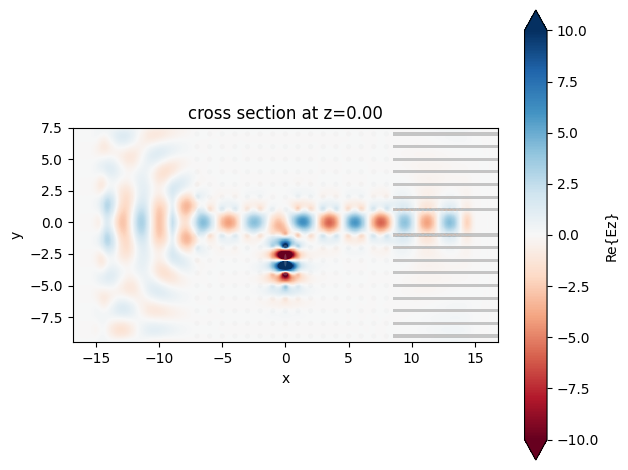

In [26]:
sim_nonlinear_data.plot_field(field_monitor_name='field before pulse', field_name="Ez", vmin=-10, vmax=10)
plt.show()

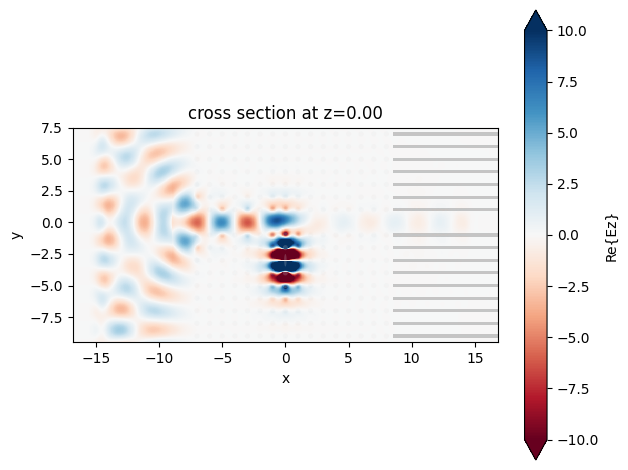

In [27]:
sim_nonlinear_data.plot_field(field_monitor_name='field after pulse', field_name="Ez", vmin=-10, vmax=10)
plt.show()

## Analytic Solution

The analytic transmission we should expect to get is given by the formula in Yanik et al.:

<center>$\frac{dS_{ref}}{dt}=i\omega_{res}(1-\frac{1}{2Q}\frac{|S_{ref}|^2}{P_0})S_{ref}-\gamma S_{ref}-\gamma S_{in}$</center>

where $P_{in}=|S_{in}|^2$ and $P_{ref}=|S_{ref}|^2$ are the input power and reflected power, respectively.

## Transmission

The transmission flux oscillates according to the source. In the figure from Yanik et al., the output results are the peak power with each optical period. We thus define a function that finds the peak power with each optical period:

In [28]:
def rolling_max(sig, freq, dt):
    interval = int(1/(dt * freq))
    N = len(sig) // interval
    times = np.linspace(0, (len(sig)-interval)*dt, N-1)
    sig_max = np.zeros(N-1)
    for i, t in enumerate(times):
        start = int(t / dt)
        stop = start + interval
        sig_max[i] = np.max(sig[start:stop])
    return times, sig_max

We plot the analytically calculated transmission against the source. This transmission matches Figure 4 from Yanik et. al. Errors in our calculations are likely due to reflections in the boundary (parameters in the DBR boundary condition), meshing size, and cavity characteristic power calculation. Differences between Tidy3D calculations and the theoretical curve may also be due to the fact that the theoretical curve does not take higher harmonics due to nonlinearity into account.

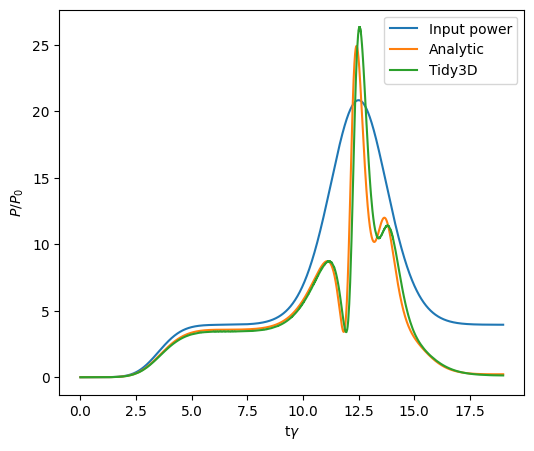

In [29]:
times_nonlinear, nonlinear_transmission = rolling_max(sim_nonlinear_data["flux t"].flux.data, detuned_freq, sim_nonlinear.dt)

# integrate a complex velocity f(x, t) using forward euler
def integrate(f, num_steps, T):
    dt = T / num_steps
    integral = np.zeros(num_steps, dtype=complex)
    time = 0
    for time_step in range(1, num_steps):
        x0 = integral[time_step - 1]
        integral[time_step] = x0 + dt*f(x0, time)
        time += dt
    return integral

interp_values = np.abs(source_time.amp_time(times_nonlinear))*np.sqrt(2*detuned_transmission)

power_input = scipy.interpolate.interp1d(times_nonlinear, interp_values)

def f(x, t):
    Sin = power_input(t)
    return 1j*gamma*(detuning - np.abs(x)**2/P_0)*x - gamma*x - gamma*power_input(t)

nt = len(times_nonlinear)
tmax = times_nonlinear[-1]
dt = tmax / nt
res = integrate(f, num_steps=nt, T=tmax)

Sin = power_input(times_nonlinear)
Sref = res

Pin = np.abs(Sin)**2
Pout = np.abs(Sin + Sref)**2

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.set_xlabel('t$\gamma$')
ax.set_ylabel('$P/P_0$')

plt.plot(times_nonlinear*gamma, Pin/P_0, label='Input power')
plt.plot(times_nonlinear*gamma, Pout/P_0, label='Analytic')
plt.plot(times_nonlinear*gamma, nonlinear_transmission/P_0, label='Tidy3D')

ax.legend()
plt.show()